# Project Overview
This project is about Sparkify digital music streaming like Spotify and Pandora. They have many users that stream their favorite songs through the offered service every day using the free-tier that play advertisements between the songs or using the premium subscription model where they stream music as free but pay a monthly flat rate. <br>
Users can downgrade, upgrade, or cancel their service at any time. So is crucial to make sure the users love the service. <br>
There are some events triggered by user use, like play song, logging out, liking a song with thumbs up, hearing an add, downgrade their service, etc. These events generate data. All these data contains the key insights for keeping the users satisfied and using their service.<br>
So the goal on these project is to predict which users are at risk to churn, either downgrading from premium to free tier or canceling their service altogether.<br>
If the identification of these users were accurate enough before they leave, some marketing offers could be send to prevent the churn. <br>
To complete this project it was provided a large dataset that contains all events described above.
Here we use a tiny subset (128MB) of the full dataset available (12GB).<br>

# Problem Statement

Problem simple definition:
>Predict which users are at risk to churn, either downgrading from premium to free tier or canceling their service altogether.

The steps to solve this problem is:
 - Load data
 - Explore and Clean data
 - Create features
 - Build Models
 - Predict churn
 
 To guide myself on this journey of exploring the data, I create some questions at the beginning of the notebook regarding the data. These questions should take into account the final target (ML) and the users segmentation. For instance:
 
 - How can we defined a user churn?
 - Is there any demographic patter?
 - Is there a numerical difference between the number of songs played between churn and non-churn users?
 - The number of days since the registration can be a significant factor to the churn users?
 - Can we ensure that if the user is liking a song with thumbs up the chance of churn reduce?
 
 It may happen that not all questions get answers, but the point is to get some insights.<br>
 
 So, after these analysis and insights, it is time to model! Our problem is a classification problem, so we will use a supervised machine learning algorithm.  
 
 For that part will use three models that were quote at the class. They are:
  - Linear Regression (lr)
  - Random Forests (rf)
  - Gradient-Boosted Tree (gbt)
  - Support Vector Machines (svm)
 
# Metrics
 To evaluete and determine the winning model, we will based on validation accuracy since the churned users are a fairly small subset, we will be using F1 score as the metric to optimize. If you want to know more about which metric choose, you can check here. 

## Import

In [1]:
# import libraries
from pyspark.sql import SparkSession

from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType

from pyspark.sql.functions import avg, substring, col, when, sum, asc, desc, countDistinct, count, udf, lit

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
from time import time

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Predicting churn") \
    .getOrCreate()

## Load Dataset


In [3]:
#load data
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

Let's take a look!

In [4]:
#Cheking the columns and their types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Clean Dataset 

In [5]:
"The number of rows in the small dataset is {}".format(df.count())

'The number of rows in the small dataset is 286500'

In [6]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

As we can see, there are some columns with missing values. <br>

| Columns  |  Null Values  |  
|----------|:-------------:|
| `artist` |  58392 |
| `firstName` |    8346   |
| `gender` | 8346 |   
| `lastName` |  8346 |
| `length` |    58392   |
| `location` | 8346 |   
| `registration` |  8346 |
| `song` | 58392   |
| `userAgent` | 8346 |   


There are some columns with many missing values. So, let's take deep into it for a better understanding of the data.<br>
The columns `artist`, `firstName` will received a closer look because it is quite possible that if one of these two has some missing value the others, will have too. <br>
Besides that, it seems a little odd that `userId` column does not have any missing value according to the columns we have missing values. So we may take a closer look on that.

In [7]:
df.where(col('firstName').isNull()).show(15)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

It looks like the columns with missing values on `firstName` columns also have missing values on `artist`, `gender`, `lastName`, `userAgent`. Besides that, the `auth` appears as "Logged out" and the `userId` column are empty. That must be the reason `userId` has no missing values.<br>
We will drop these missing values.

In [8]:
df.where(col('artist').isNull()).show(15)

+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null| Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null| Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null| Logged In|    Mi

The missing values at the `artist` column seems to be correlated to the ones on `song`. But if we look at the `page` column it is clear that they are non-music related actions. So we may wanna keep it. 

In [9]:
#drop empty string
df_clean = df.filter(df['userId'] != "")

#drop missing values 
df_clean = df_clean.dropna(how = 'any', subset = ['sessionId', 'firstName'] )

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Basics

**Numerical features**

In [10]:
# Quick descriptive statistics
df_clean.select(['itemInSession', 'length', 'registration', 'ts']).describe().show()

+-------+------------------+-----------------+--------------------+--------------------+
|summary|     itemInSession|           length|        registration|                  ts|
+-------+------------------+-----------------+--------------------+--------------------+
|  count|            278154|           228108|              278154|              278154|
|   mean|114.89918174824018|249.1171819778458|1.535358834084427...|1.540958915431871...|
| stddev|  129.851729399489|99.23517921058361| 3.291321616327586E9|1.5068287123306298E9|
|    min|                 0|          0.78322|       1521380675000|       1538352117000|
|    max|              1321|       3024.66567|       1543247354000|       1543799476000|
+-------+------------------+-----------------+--------------------+--------------------+



**Categorical features**

In [11]:
#select some features to know the possible values
cat_feat = ['auth', 'gender', 'level', 'location',
            'method', 'page', 'status']

In [12]:
for feature in cat_feat:
    print(f"Possible values of '{feature}':")
    print([x[feature] for x in df_clean.select(feature).dropDuplicates().collect()])
    print("\n")

Possible values of 'auth':
['Cancelled', 'Logged In']


Possible values of 'gender':
['F', 'M']


Possible values of 'level':
['free', 'paid']


Possible values of 'location':
['Gainesville, FL', 'Atlantic City-Hammonton, NJ', 'Deltona-Daytona Beach-Ormond Beach, FL', 'San Diego-Carlsbad, CA', 'Cleveland-Elyria, OH', 'Kingsport-Bristol-Bristol, TN-VA', 'New Haven-Milford, CT', 'Birmingham-Hoover, AL', 'Corpus Christi, TX', 'Dubuque, IA', 'Las Vegas-Henderson-Paradise, NV', 'Indianapolis-Carmel-Anderson, IN', 'Seattle-Tacoma-Bellevue, WA', 'Albany, OR', 'Winston-Salem, NC', 'Bakersfield, CA', 'Los Angeles-Long Beach-Anaheim, CA', 'Minneapolis-St. Paul-Bloomington, MN-WI', 'San Francisco-Oakland-Hayward, CA', 'Phoenix-Mesa-Scottsdale, AZ', 'Allentown-Bethlehem-Easton, PA-NJ', 'Miami-Fort Lauderdale-West Palm Beach, FL', 'Selma, AL', 'Dayton, OH', 'San Jose-Sunnyvale-Santa Clara, CA', 'Bridgeport-Stamford-Norwalk, CT', 'Price, UT', 'Providence-Warwick, RI-MA', 'Columbus, GA-AL', 'Greenvil

### Define Chrun

1) How many unique users are on the sample Dataset?


In [12]:
users_count = df_clean.select(countDistinct('userId'))
users_count.show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



2) What are the values page?

In [13]:
df_clean.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



3) How many users click on "Cancellation Confirmation" page? Who are they?

In [14]:
df_clean.filter(df_clean['page'] == "Cancellation Confirmation").select(countDistinct('userId')).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                    52|
+----------------------+



In [15]:
df_churn_user = df_clean.filter(df_clean['page'] == "Cancellation Confirmation").select('userId').dropDuplicates()
df_churn_user.show(10)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
+------+
only showing top 10 rows



**Create feature Chrun**

In [16]:
churn_users = df_clean.filter(df_clean['page'] == "Cancellation Confirmation").select('userId').dropDuplicates()
churn_users_list = [row['userId'] for row in churn_users.collect()]
df_clean = df_clean.withColumn('churn', df_clean['userId'].isin(churn_users_list))

### Exploration

Turn the Spark SQL dataframe to pandas for better visualization 

In [17]:
df_pandas = df_clean.select('*').toPandas()

In [18]:
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False


To take a deep look, we selected some specific features that, in my opinion, makes more sense to explore. 

**Churn vs Gender** 

In [23]:
gender_churn = df_clean.dropDuplicates(['userId']).groupBy(['churn', 'gender']).count().toPandas()
gender_churn.head()

,churn,gender,count
0,True,F,20
1,False,M,89
2,True,M,32
3,False,F,84


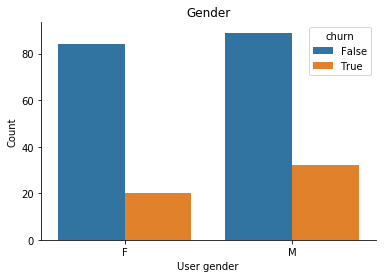

In [20]:
ax = sns.barplot(x = 'gender', y = 'count', hue = 'churn', data=gender_churn)
plt.xlabel('User gender')
plt.ylabel('Count')
plt.title('Gender')
sns.despine(ax=ax);

To compare the both genders, we will create a rate.

In [24]:
# rate feature for better understanding
gender_sum = gender_churn.groupby(['churn']).sum()['count'].to_frame().rename(columns = {'count' : 'sum'})
gender_churn = gender_churn.join(gender_sum, on = 'churn')
gender_churn['rate'] = gender_churn['count']/gender_churn['sum']
gender_churn

,churn,gender,count,sum,rate
0,True,F,20,52,0.384615
1,False,M,89,173,0.514451
2,True,M,32,52,0.615385
3,False,F,84,173,0.485549


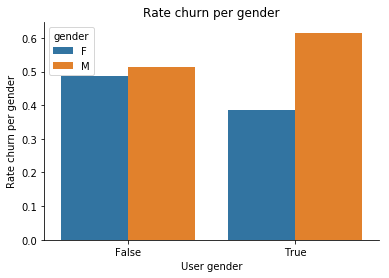

In [26]:
ax = sns.barplot(x = 'churn', y = 'rate', hue = 'gender', data=gender_churn)
plt.xlabel('User gender')
plt.ylabel('Rate churn per gender')
plt.title('Rate churn per gender')
sns.despine(ax=ax);

So we can say that male gender seems to be more likely to churn than womens.

**Churn vs page**

In [24]:
page_churn  = df_clean.filter(df_clean['page'] != "NextSong").\
              groupBy(['churn', 'page']).\
              count().toPandas().\
              sort_values(by = 'count')
page_churn.head()

,churn,page,count
17,True,Submit Downgrade,9
33,True,Error,32
10,True,Submit Upgrade,32
24,True,Cancel,52
12,True,Cancellation Confirmation,52


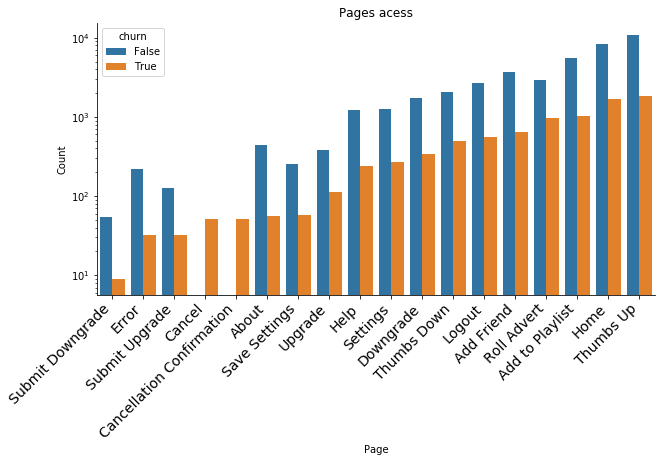

In [25]:
fig = plt.figure(figsize=(10, 5))
ax = sns.barplot(x = 'page' , y = 'count', hue = 'churn', data = page_churn, log = True)
plt.xlabel('Page')
plt.ylabel('Count')
plt.title('Pages acess')
plt.xticks(rotation=45, ha='right', fontsize=14)
sns.despine(ax=ax);

In [26]:
# rate feature for better understanding
page_sum = page_churn.groupby(['page']).sum()['count'].to_frame().rename(columns = {'count' : 'sum'})
page_churn = page_churn.join(page_sum, on = 'page')
page_churn['rate'] = page_churn['count']/page_churn['sum']
page_churn.head()

,churn,page,count,sum,rate
17,True,Submit Downgrade,9,63,0.142857
33,True,Error,32,252,0.126984
10,True,Submit Upgrade,32,159,0.201258
24,True,Cancel,52,52,1.000000
12,True,Cancellation Confirmation,52,52,1.000000


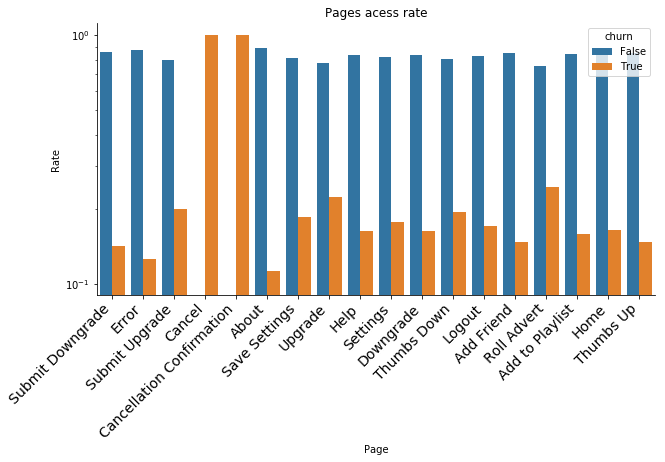

In [27]:
fig = plt.figure(figsize=(10, 5))
ax = sns.barplot(x = 'page' , y = 'rate', hue = 'churn', data = page_churn, log = True)
plt.xlabel('Page')
plt.ylabel('Rate')
plt.title('Pages acess rate')
plt.xticks(rotation=45, ha='right', fontsize=14)
sns.despine(ax=ax);

The "Cancel" and "Cancellation Confirmation" pages have only churned users, and it makes sense since the way we defined churn feature. But look how "Thumbs up", "Add Playlist" and "Add Friend" seems to have less churn users rate. There are some features like "Submit Upgrade", "Upgrade", "Thumbs down", "Downgrade" and "Logout" that appears to have a higher churn rate. We will take a better look. 

**Page vs level for churn users**

In [27]:
level_page_churn = df_clean.filter(df_clean['churn'] == 1).\
              groupBy(['churn', 'page', 'level']).\
              count().toPandas().\
              sort_values(by = 'count')
level_page_churn.head()

,churn,page,level,count
24,True,Submit Downgrade,paid,9
11,True,Error,free,12
18,True,Error,paid,20
6,True,Save Settings,free,20
10,True,Cancel,free,21


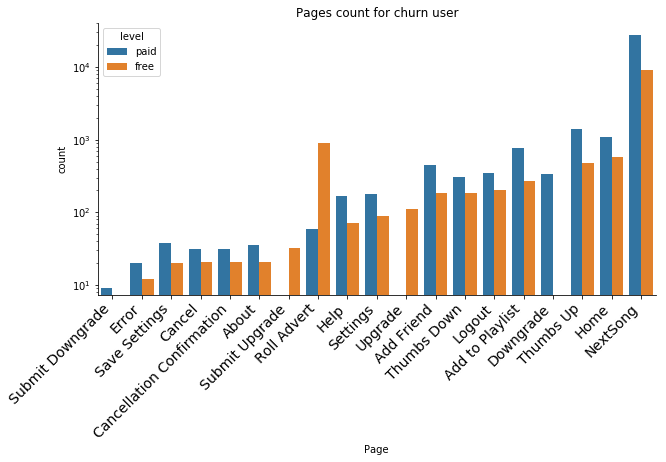

In [28]:
fig = plt.figure(figsize=(10, 5))
ax = sns.barplot(x = 'page' , y = 'count', hue = 'level', data = level_page_churn , log = True)
plt.xlabel('Page')
plt.ylabel('count')
plt.title('Pages count for churn user')
plt.xticks(rotation=45, ha='right', fontsize=14)
sns.despine(ax=ax);

The rate between premium users and free seems close for each page. And the number of premium users cancel or confirm cancellation is bigger. It means that premium users has more chance to churn. <br>
Now, look at the "Thumbs Down" page. It seems be a important feature for churn prediction. 

**Page vs level for non-churn users**

In [30]:
level_page_nchurn = df_clean.filter(df_clean['churn'] == 0).\
              groupBy(['churn', 'page', 'level']).\
              count().toPandas().\
              sort_values(by = 'count')
level_page_nchurn.head()

,churn,page,level,count
19,False,Error,free,41
7,False,Submit Downgrade,paid,54
29,False,Save Settings,free,65
20,False,About,free,72
4,False,Submit Upgrade,free,127


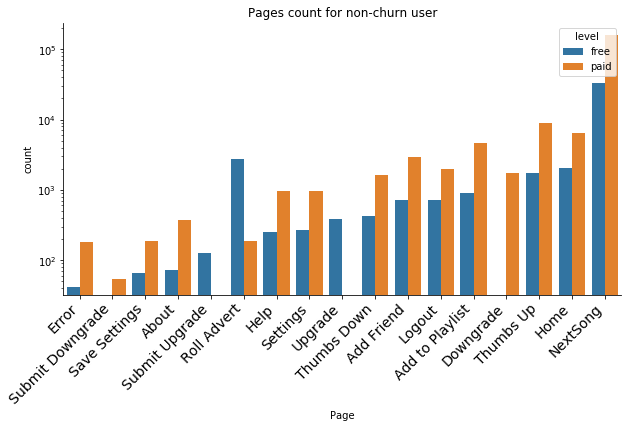

In [31]:
fig = plt.figure(figsize=(10, 5))
ax = sns.barplot(x = 'page' , y = 'count', hue = 'level', data = level_page_nchurn , log = True)
plt.xlabel('Page')
plt.ylabel('count')
plt.title('Pages count for non-churn user')
plt.xticks(rotation=45, ha='right', fontsize=14)
sns.despine(ax=ax);

**Churn vs level**

In [31]:
level_churn  = df_clean.groupBy(['churn', 'level']).\
              count().toPandas().\
              sort_values(by = 'count')
level_churn.head()

,churn,level,count
3,True,free,12388
2,True,paid,32476
0,False,free,43333
1,False,paid,189957


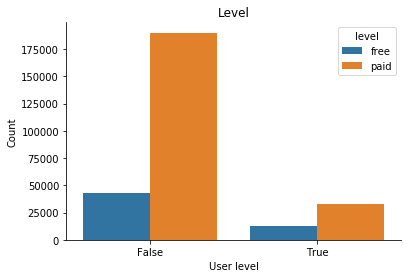

In [32]:
ax = sns.barplot(x = 'churn', y = 'count', hue = 'level', data=level_churn)
plt.xlabel('User level')
plt.ylabel('Count')
plt.title('Level')
sns.despine(ax=ax);

In [33]:
# rate feature for better understanding
level_sum = level_churn.groupby(['churn']).sum()['count'].to_frame().rename(columns = {'count' : 'sum'})
level_churn = level_churn.join(level_sum, on = 'churn')
level_churn['rate'] = level_churn['count']/level_churn['sum']
level_churn.head()

,churn,level,count,sum,rate
3,True,free,12388,44864,0.276123
2,True,paid,32476,44864,0.723877
0,False,free,43333,233290,0.185747
1,False,paid,189957,233290,0.814253


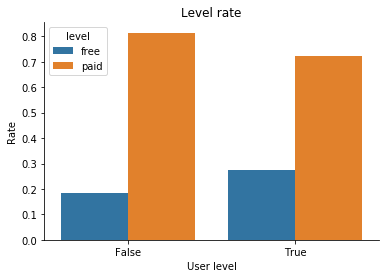

In [35]:
ax = sns.barplot(x = 'churn', y = 'rate', hue = 'level', data=level_churn)
plt.xlabel('User level')
plt.ylabel('Rate')
plt.title('Level rate')
sns.despine(ax=ax);

As we thought, there are more premium users churn than free users. It can be because free users may just stop using the service by loging out, but premium users don't. Either way, the level seems to have some impact to classify a user.


**Churn vs Number of songs played** 

In [36]:
songs_count_churn = df_pandas.query('churn == 1').dropna(subset = ['song']).groupby('userId').\
                    count().reset_index()
songs_count_churn = songs_count_churn[['userId', 'song']].rename(columns = {'song': 'played_songs'})
songs_count_n_churn = df_pandas.query('churn == 0').dropna(subset = ['song']).groupby('userId').\
                    count().reset_index()
songs_count_n_churn = songs_count_n_churn[['userId', 'song']].rename(columns = {'song': 'played_songs'})

"Average number of songs played for churn users are {} and for non-churn users are {}.".\
format(songs_count_churn.played_songs.mean(), songs_count_n_churn.played_songs.mean())

'Average number of songs played for churn users are 699.8846153846154 and for non-churn users are 1108.1734104046243.'

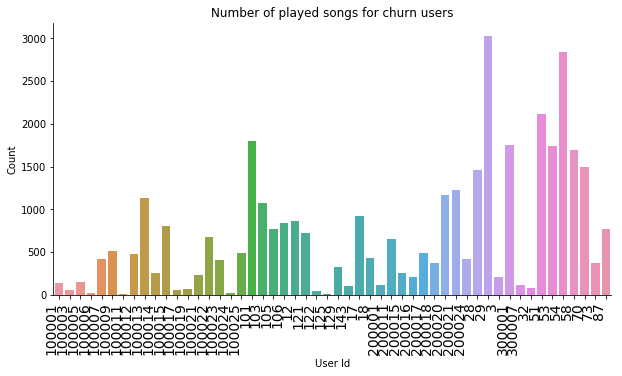

In [37]:
fig = plt.figure(figsize=(10, 5))
ax = sns.barplot(x = 'userId' , y = 'played_songs', data = songs_count_churn)
plt.xlabel('User Id')
plt.ylabel('Count')
plt.title('Number of played songs for churn users')
plt.xticks(rotation=90, ha='right', fontsize=14)
sns.despine(ax=ax);

It was surprising that both means were not more distant. But as we can see, we have some outliers that can be the cause of it. These outliers can bem important, so we won't remove.

**Churn vs time since registration**

In [38]:
# time in days since the registration
df_pandas['time_reg'] = (df_pandas['ts'] - df_pandas['registration'])/1000/3600/24
time_since_reg = df_pandas.groupby(['userId', 'churn']).agg({'time_reg': 'max'})
time_since_reg.head()

,,time_reg
userId,churn,
10,False,51.762650
100,False,64.873773
100001,True,44.800220
100002,False,160.472072
100003,True,22.748113


In [39]:
time_since_reg.groupby('churn').mean()

,time_reg
churn,
False,86.620619
True,57.305993


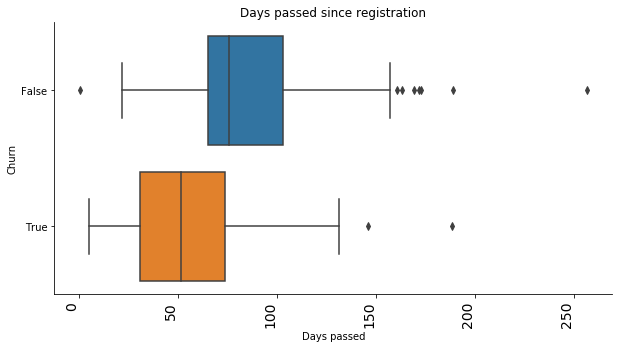

In [40]:
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(x = 'time_reg' , y = 'churn', data = time_since_reg.reset_index(), orient = 'h')
plt.xlabel('Days passed')
plt.ylabel('Churn')
plt.title('Days passed since registration')
plt.xticks(rotation=90, ha='right', fontsize=14)
sns.despine(ax=ax);

If the past days since registration are higher than 140 the chance of the user churn falls dramatically. That is a very important feature.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

The features selected are: 
 - gender
 - pages (Tumbs down/Up, Add playlist and Add friend)
 - level
 - number of songs played
 - time since the registration

**Feature Gender**

Feature gender can be important because of sociological reasons. 

In [41]:
f_gender = df_clean.select('userId', 'gender').dropDuplicates().\
     replace(['F', 'M'], ['1', '0'], 'gender').\
     select('userId', col('gender').cast('int'))

**Feature Thumbs up/down**

In addition to what we saw earlier in the graphics, from the business point of view, having a user iterating positively or negatively is a great way to predict behavior and to serving as an engagement or service quality meter 

In [42]:
f_thumb_up = df_clean.select('userID','page').filter(df_clean.page == "Thumbs Up").\
     groupBy('userID').count().withColumnRenamed('count', 'n_thumb_up') 

f_thumb_down = df_clean.select('userID','page').filter(df_clean.page == "Thumbs Down").\
     groupBy('userID').count().withColumnRenamed('count', 'n_thumb_down') 

The features below were selected because they show more about the behavior of the user. Thus, can be important to measure the engagement, loyalty and satisfaction.

**Feature level**

In [43]:
f_level = df_clean.select('userId', 'level').dropDuplicates().\
     replace(['paid', 'free'], ['1', '0'], 'level').\
     select('userId', col('level').cast('int'))

**Feature Add to playlist**

In [44]:
f_playlist = df_clean.select('userID','page').filter(df_clean.page == "Add to Playlist").\
         groupBy('userID').count().withColumnRenamed('count', 'add_to_playlist')

**Feature Add friend**

In [45]:
f_friend = df_clean.select('userID','page').filter(df_clean.page == "Add Friend").\
        groupBy('userID').count().withColumnRenamed('count', 'add_friend')

**Feature Number of songs played**

In [46]:
f_songs = df_clean.filter(df_clean.song != 'null').\
      groupBy('userId').agg(count(df_clean.song).alias('playedSongs')).orderBy('userId').\
      select(['userId','playedSongs'])

**Feature time since the registration**

In [47]:
f_pdays = df_clean.select('userId','registration','ts').\
    withColumn('pdays_reg',(df_clean.ts - df_clean.registration)).\
    groupBy('userId').agg({'pdays_reg':'max'}).\
    withColumnRenamed('max(pdays_reg)','pdays_reg').\
    select('userId', (col('pdays_reg')/1000/3600/24).alias('pdays_reg'))

**Label Churn**

In [48]:
f_label = df_clean.select('userId', col('churn').alias('label')).dropDuplicates()
f_label = f_label.withColumn('label', f_label.label.cast('int'))
f_label.show()

+------+-----+
|userId|label|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
|    50|    0|
|200002|    0|
|    30|    0|
|     8|    0|
|100011|    1|
|100012|    1|
|     4|    0|
|    65|    0|
|   101|    1|
|    13|    0|
|   153|    0|
|    42|    0|
|100014|    1|
|    94|    0|
|    62|    0|
|   114|    0|
+------+-----+
only showing top 20 rows



Join all the features

In [49]:
df_final = df_clean.dropDuplicates(['userId']).sort('userId').select(['userId'])
for feature in [f_gender, f_level, f_thumb_up, f_thumb_down, f_playlist, f_friend, f_songs, f_pdays, f_label]:
    df_final = df_final.join(feature,'userId')

In [50]:
df_final.show()

+------+------+-----+----------+------------+---------------+----------+-----------+------------------+-----+
|userId|gender|level|n_thumb_up|n_thumb_down|add_to_playlist|add_friend|playedSongs|         pdays_reg|label|
+------+------+-----+----------+------------+---------------+----------+-----------+------------------+-----+
|100010|     1|    0|        17|           5|              7|         4|        275|  55.6436574074074|    0|
|200002|     0|    0|        21|           6|              8|         4|        387| 70.07462962962963|    0|
|200002|     0|    1|        21|           6|              8|         4|        387| 70.07462962962963|    0|
|   124|     1|    1|       171|          41|            118|        74|       4079|131.55591435185184|    0|
|    51|     0|    1|       100|          21|             52|        28|       2111|19.455844907407407|    1|
|     7|     0|    0|         7|           1|              5|         1|        150| 72.77818287037037|    0|
|    15|  

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

**Split data**

To avoid feature with larger scale bias our model we need to standardize them. But before that, we need vectorize them.

In [51]:
# using vector assembler
features = ['gender', 'level', 'n_thumb_up', 'n_thumb_down',
            'add_to_playlist', 'add_friend', 'playedSongs',
            'pdays_reg']
assembler = VectorAssembler(inputCols = features, outputCol = 'NumFeatures')
df = assembler.transform(df_final)

In [52]:
# scaling features
scaler = StandardScaler(inputCol = 'NumFeatures', outputCol = 'features', withStd=True)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)

In order to have a train, validation and test datasets we will apply randomSplit twice.

In [53]:
# train test split
train, val_test = df.randomSplit([0.7, 0.3], seed=42)
validation, test = val_test.randomSplit([0.5, 0.5], seed=42)

So, the first before starts with the models application is to create a naive baseline. 

**Baseline creation**<br>
The idea of this baseline is to create a predictor that returns churn = 0, that is, all users labelled as churn.

In [85]:
pred_baseline = validation.withColumn('prediction', lit(0.0))

In [86]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Test set metric:')
print('F-1 Score:{}'.format(evaluator.evaluate(pred_baseline, {evaluator.metricName: "f1"})))

Test set metric:
F-1 Score:0.6082758620689656


With the baseline metric set, we can start trying some models. As we see in the extra curricular class, to tunning the model it will be use Parameter Grid and Cross Validation.<br>
Besides that, the evaluator selected was MulticlassClassificationEvaluator using the f1-score metric.

**Logistic Regression**

In [57]:
# initialize classifier
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

# set evaluator
evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          evaluator=evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [62]:
start = time()
cvModel_lr = crossval_lr.fit(train)
end = time()
"Time training {} seconds".format(round(end - start, 2))

'Time training 332.18 seconds'

In [71]:
cvModel_lr.avgMetrics

[0.7740952816246934]

In [63]:
results_lr = cvModel_lr.transform(validation)

In [64]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metric:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Test set metric:
F-1 Score:0.6819923371647509


**Random Forest**

In [65]:
# initialize classifier
rf = RandomForestClassifier()

# set evaluator
evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [66]:
start = time()
cvModel_rf = crossval_rf.fit(train)
end = time()
"Time training {} seconds".format(round(end - start, 2))

'Time training 401.65 seconds'

In [69]:
cvModel_rf.avgMetrics

[0.8521807720297101]

In [72]:
results_rf = cvModel_rf.transform(validation)

In [73]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metric:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))

Test set metric:
F-1 Score:0.964768778401497


**Gradient-Boosted Trees**

In [75]:
# initialize classifier
gbt = GBTClassifier(maxIter=10,seed=42)

# set evaluator
evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [76]:
start = time()
cvModel_gbt = crossval_gbt.fit(train)
end = time()
"Time training {} seconds".format(round(end - start, 2))

'Time training 851.78 seconds'

In [77]:
cvModel_gbt.avgMetrics

[0.8804080431353158]

In [78]:
results_gbt = cvModel_gbt.transform(validation)

In [79]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metric:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))

Test set metric:
F-1 Score:1.0


**Support Vector Machine**

In [80]:
# initialize classifier
svm = LinearSVC(maxIter=10)

# set evaluator
evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_svm = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [81]:
start = time()
cvModel_svm = crossval_svm.fit(train)
end = time()
"Time training {} seconds".format(round(end - start, 2))

'Time training 507.61 seconds'

In [82]:
cvModel_svm.avgMetrics

[0.7111892195746541]

In [83]:
results_svm= cvModel_svm.transform(validation)

In [84]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metric:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "f1"})))

Test set metric:
F-1 Score:0.6082758620689656


Although the Gradient-Boosted Trees performed better, the excessive high score on the validation test 
may have been caused by the unbalance of the classes. So we choose the random forest because of the time of performance. 

**Select best model**<br>


In [90]:
# Optimize a Random Forest model through Grid Search
model = RandomForestClassifier()
param_grid = ParamGridBuilder().\
     addGrid(model.numTrees, [5, 15]).\
     addGrid(model.maxDepth, [5, 10]).\
     build()

crossval_rf = CrossValidator(estimator = model,
                         estimatorParamMaps = param_grid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 3)

cvModel_rf = crossval_rf.fit(train)
results = cvModel_rf.transform(test)

In [92]:
cvModel_rf.avgMetrics

[0.8712121385019901,
 0.8968261881267063,
 0.8479459519703421,
 0.9178505163621689]

In [91]:
print('Test set metrics:')
print('F-1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))

Test set metrics:
F-1 Score:0.7946666666666666


# Conclusion

## Reflection

This project provided an opportunity to familiarize myself with loading, analyzing, cleaning and predicting using big data. It was very challenging, but joyfull. <br>

One of the most challenging points was getting used to the syntax. As similar as it was to python, it took me a while to get used to and understand what I was doing. <br>
 
It was amazing learn how to manipulate large and realistic datasets using Spark to engineer relevant features for predicting churn and how to use Spark MLlib to build machine learning models, far beyond what could be done with non-distributed technologies.


## Improvement 

To improve the process many thing can be made, like balance the class predict. This process could be done using oversampling, but it has do be done carefully. A common mistake when oversampling is applying the oversample before the cross validation. The problem of this approach is that at some point the training and validation set contain the same sample, resulting in overfitting and misleading results. <br>

The right way is shown in the figure above. We need to do the oversampling after the cross validation, in order to avoid using the same data for training and validation. This way we avoid overfitting and get reliable results.
It is possible to know more in: https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation.<br>

Another point is to treat the skewness of the features. Many models make assumptions about the features being normally distributed, so transforming our features into more normal features can boost our predictive ability.The model based on tree decisions are not too senstive for skewness but it can be improved. 